<a href="https://colab.research.google.com/github/Alireza-Pournabavi/GitFL-boxplot/blob/main/GitFL_implemetation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source:

https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029

# **1. Import all relevant packages**

In [ ]:
#### imports library

import sys, os
import math
import time
import threading as th
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from femnist_dataset import FEMNIST
from torch.utils.data.dataset import Dataset
torch.backends.cudnn.benchmark = True

In [ ]:
[
sys.version,
'GPU',
['is available', torch.cuda.is_available()],
['device count', torch.cuda.device_count()],
['current device', torch.cuda.current_device()],
['device', torch.cuda.device(0)],
['get device name', torch.cuda.get_device_name(0)],
['get_num_threads', torch.get_num_threads()],
'CPU',
['cpu_count', os.cpu_count()],
['is available', torch.cpu.is_available()],
['device count', torch.cpu.device_count()],
]

['3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]',
 'GPU',
 ['is available', True],
 ['device count', 1],
 ['current device', 0],
 ['device', <torch.cuda.device at 0x7b9872b8a140>],
 ['get device name', 'Tesla T4'],
 ['get_num_threads', 1],
 'CPU',
 ['cpu_count', 2],
 ['is available', True],
 ['device count', 1]]

# **2. Loading and Dividing Datasets**

## 2.0 Plot

In [ ]:
def plot_distribution(dataloaders, num_client, num_label):
  plt.figure()
  ax = plt.gca()
  left = np.zeros(num_client)
  for idx, client in enumerate(dataloaders):
    label_count = np.zeros(num_label)
    for _, labels in client:
      for label in labels:
        label_count[label.item()] += 1
    for y, cnts in enumerate(label_count):
      ax.barh(idx, width=cnts, label=y, left=left[idx])
      left[idx] += cnts
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Number of Images')
  plt.ylabel('Number of Clients')
  plt.title('Data Distribution Among Clients')
  plt.show()

## 2.1 IID Datasets

### 2.1.1 CIFAR-10

In [ ]:
#### Loading and Dividing CIFAR-10
def iid_cifar10(num_clients, batch_size):
    # Image augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading CIFAR10 using torchvision.datasets
    traindata = datasets.CIFAR10('./data/cifar10', train=True, download=True,
                                 transform=transform_train)

    # Dividing the training data into num_clients, with each client having equal number of images
    traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in
                                                                range(num_clients)])

    # Creating a pytorch loader for a Deep Learning model
    train_data = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

    # Draw a Plot
    plot_distribution(train_data, num_clients, len(traindata.classes))

    # Normalizing the test images
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading the test images and thus converting them into a test_loader
    test_data = torch.utils.data.DataLoader(datasets.CIFAR10('./data/cifar10', train=False, transform=transform_test), batch_size=batch_size, shuffle=True)

    return train_data, test_data

### 2.1.2 CIFAR-100

In [ ]:
#### Loading and Dividing CIFAR-100
def iid_cifar100(num_clients, batch_size):
    # Image augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading CIFAR100
    traindata = datasets.CIFAR100('./data/cifar100', train=True, download=True, transform=transform_train)

    # Dividing the training data into num_clients, with each client having equal number of images
    traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in
                                                                range(num_clients)])

    # Creating a pytorch loader for a Deep Learning model
    train_data = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

    # Draw a Plot
    plot_distribution(train_data, num_clients, len(traindata.classes))

    # Normalizing the test images
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading the test images and thus converting them into a test_loader
    test_data = torch.utils.data.DataLoader(datasets.CIFAR100('./data/cifar100', train=False, transform=transform_test), batch_size=batch_size, shuffle=True)

    return train_data, test_data

### 2.1.3 EMNIST

In [ ]:
#### Loading and Dividing EMNIST
def iid_emnist(num_clients, batch_size):
    # Image augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading EMNIST using torchvision.datasets
    traindata = datasets.EMNIST('./data/emnist', train=True, download=True, transform=transform_train)

    # Dividing the training data into num_clients, with each client having equal number of images
    traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in
                                                                range(num_clients)])

    # Creating a pytorch loader for a Deep Learning model
    train_data = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

    # Draw a Plot
    plot_distribution(train_data, num_clients, len(traindata.classes))

    # Normalizing the test images
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading the test images and thus converting them into a test_loader
    test_data = torch.utils.data.DataLoader(datasets.EMNIST('./data/emnist', train=False, transform=transform_test), batch_size=batch_size, shuffle=True)

    return train_data, test_data

## 2.2 Non-IID Datasets

### 2.2.1 CIFAR-10

In [ ]:
#### Loading and Dividing CIFAR-10
def non_iid_cifar10(num_clients, batch_size, alpha):
    # Image augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading CIFAR10 using torchvision.datasets
    traindata = datasets.CIFAR10('./data/cifar10', train=True, download=True,
                                 transform=transform_train)

    # Get the targets and count the number of classes
    targets = np.array(traindata.targets)
    num_classes = np.max(targets) + 1

    # Create a list to hold data indices for each client
    client_dict = {i: [] for i in range(num_clients)}

    # For each class, split the data across the clients using Dirichlet distribution
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Get the number of samples for each client
        num_samples_per_client = np.round(proportions * len(idx_k)).astype(int)
        # Correct any rounding errors
        num_samples_per_client[-1] = len(idx_k) - np.sum(num_samples_per_client[:-1])

        start = 0
        for i in range(num_clients):
            size = num_samples_per_client[i]
            client_dict[i].extend(idx_k[start:start+size])
            start += size

    # Create a data loader for each client
    train_data = [torch.utils.data.DataLoader(torch.utils.data.Subset(traindata, client_dict[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]

    # Draw a Plot
    plot_distribution(train_data, num_clients, len(traindata.classes))

    # Normalizing the test images
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading the test images and thus converting them into a test_loader
    test_data = torch.utils.data.DataLoader(datasets.CIFAR10('./data/cifar10', train=False, transform=transform_test), batch_size=batch_size, shuffle=True)

    return train_data, test_data

### 2.2.2 CIFAR-100

In [ ]:
#### Loading and Dividing CIFAR-100
def non_iid_cifar100(num_clients, batch_size, alpha):
    # Image augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading CIFAR100 using torchvision.datasets
    traindata = datasets.CIFAR100('./data/cifar100', train=True, download=True,
                                 transform=transform_train)

    # Get the targets and count the number of classes
    targets = np.array(traindata.targets)
    num_classes = np.max(targets) + 1

    # Create a list to hold data indices for each client
    client_dict = {i: [] for i in range(num_clients)}

    # For each class, split the data across the clients using Dirichlet distribution
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Get the number of samples for each client
        num_samples_per_client = np.round(proportions * len(idx_k)).astype(int)
        # Correct any rounding errors
        num_samples_per_client[-1] = len(idx_k) - np.sum(num_samples_per_client[:-1])

        start = 0
        for i in range(num_clients):
            size = num_samples_per_client[i]
            client_dict[i].extend(idx_k[start:start+size])
            start += size

    # Create a data loader for each client
    train_data = [torch.utils.data.DataLoader(torch.utils.data.Subset(traindata, client_dict[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]

    # Draw a Plot
    plot_distribution(train_data, num_clients, len(traindata.classes))

    # Normalizing the test images
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading the test images and thus converting them into a test_loader
    test_data = torch.utils.data.DataLoader(datasets.CIFAR100('./data/cifar100', train=False, transform=transform_test), batch_size=batch_size, shuffle=True)

    return train_data, test_data

### 2.2.3 EMNIST

In [ ]:
#### Loading and Dividing EMNIST
def non_iid_emnist(num_clients, batch_size, alpha):
    # Image augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading EMNIST using torchvision.datasets
    traindata = datasets.EMNIST('./data/emnist', train=True, download=True,
                                 transform=transform_train)

    # Get the targets and count the number of classes
    targets = np.array(traindata.targets)
    num_classes = np.max(targets) + 1

    # Create a list to hold data indices for each client
    client_dict = {i: [] for i in range(num_clients)}

    # For each class, split the data across the clients using Dirichlet distribution
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Get the number of samples for each client
        num_samples_per_client = np.round(proportions * len(idx_k)).astype(int)
        # Correct any rounding errors
        num_samples_per_client[-1] = len(idx_k) - np.sum(num_samples_per_client[:-1])

        start = 0
        for i in range(num_clients):
            size = num_samples_per_client[i]
            client_dict[i].extend(idx_k[start:start+size])
            start += size

    # Create a data loader for each client
    train_data = [torch.utils.data.DataLoader(torch.utils.data.Subset(traindata, client_dict[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]

    # Draw a Plot
    plot_distribution(train_data, num_clients, len(traindata.classes))

    # Normalizing the test images
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Loading the test images and thus converting them into a test_loader
    test_data = torch.utils.data.DataLoader(datasets.EMNIST('./data/emnist', train=False, transform=transform_test), batch_size=batch_size, shuffle=True)

    return train_data, test_data

# **3. GitFL - Adaptive Asynchronous Federated Learning**

### 3.1 Merging

In [ ]:
#### Asynchronous Federated Learning
def merging(global_model, client_models, versions, global_opt, opt):
    # Create Dataframe with client_models, optimizer, versions
    df = pd.DataFrame(list(zip(client_models, opt, versions)),
                      columns=['client_models', 'optimizer', 'versions'])

    # boxplots calculations and Remove Outlier Versions
    df = df.sort_values(by='versions')

    q1 = df['versions'].quantile(0.25)
    q3 = df['versions'].quantile(0.75)
    iqr = q3 - q1
    qmin = q1 - (1.5 * iqr)
    qmax = q3 + (1.5 * iqr)
    mini = df['versions'].quantile(0)
    maxi = df['versions'].quantile(1)

    if mini > qmin:
        minimum = mini
    else:
        minimum = qmin

    if maxi <= qmax:
        maximum = maxi
    else:
        maximum = qmax

    for i, row in df['versions'].items():
        if row < minimum or maximum < row:
            df = df.drop(index=i)

    # Update Parameter and Merge & Average Layers Weight by Ensemble Learning
    parameter_state_dict = {}
    for key in global_model.state_dict():
        x = 0
        for _, client in df.iterrows():
            if client['versions'] == 0:
                # print(f"Warning: version for client is zero")
                pass
            elif torch.isnan(client['client_models'].state_dict()[key]).any():
                # print(f"Warning: NaN detected in parameters for client")
                pass
            else:
                x += client['client_models'].state_dict()[key] * client['versions']

        try:
            parameter_state_dict[key] = x / sum(df['versions'])
        except ZeroDivisionError:
            # print("model exception")
            parameter_state_dict[key] = global_model.state_dict()[key]
    global_model.load_state_dict(parameter_state_dict)

    # Update Hyper Parameter and Merge & Average Optimization Parameter
    for key in ['lr', 'momentum', 'dampening', 'weight_decay']:
        x = 0
        for _, client in df.iterrows():
            if client['versions'] == 0:
                # print(f"Warning: version for client is zero")
                pass
            else:
                x += client['optimizer'].state_dict()['param_groups'][0][key] * client['versions']
        try:
            global_opt.state_dict()['param_groups'][0][key] = x / sum(df['versions'])
        except ZeroDivisionError:
            # print("opt exception")
            global_opt.state_dict()['param_groups'][0][key] = global_opt.state_dict()['param_groups'][0][key]

    return global_model, global_opt

### 3.2 Version Control

In [ ]:
def version_control(versions):
    sum_versions = sum(versions)
    v_ctrl = []
    for i in versions:
        v_ctrl.append((i - sum_versions) / len(versions))
    return v_ctrl

### 3.3 Client Selection

In [ ]:
def client_selection(Tc, Tt, v_ctrl, active_client):
    # Calculate Version Reward (Rv)
    sum_Tt = sum(Tt) / len(Tt)
    max_Tt = max(Tt)
    sum_max_Tt = []
    for i in Tt:
        x = (i - sum_Tt)
        try:
            x /= max_Tt
        except ZeroDivisionError:
            x = 0
        sum_max_Tt.append(x)
    Rv = [a * b for a, b in zip(sum_max_Tt, v_ctrl)]

    # Calculate Curiosity Reward (Rc)
    Rc = []
    for i in Tc:
        try:
            Rc.append(1 / math.sqrt(i))
        except ZeroDivisionError:
            Rc.append(0)

    # Calculate Version-Curiosity Reward (R)
    R_sum = [a + b for a, b in zip(Rv, Rc)]
    R = [max(0, r) for r in R_sum]

    # Calculate Price (P)
    sum_R = sum(R)
    P = []
    for i in R:
        try:
            P.append(i / sum_R)
        except ZeroDivisionError:
            P.append(0)

    # Select High Price Client then Not Active
    maxi = 0
    client_index = None
    for i, value in enumerate(P):
        if value >= maxi:
            if i not in active_client:
                maxi = value
                client_index = i
    active_client.append(client_index)

    return client_index

### 3.4 Model Pull

In [ ]:
def model_pull(global_model, client_model, global_opt, opt, v_ctrl):
    y_max = max(10 + v_ctrl, 2)

    # Aggregation Parameter of Client Model and Global Model
    parameter_state_dict = {}
    for key in global_model.state_dict():
        x = y_max * client_model.state_dict()[key] + global_model.state_dict()[key]
        parameter_state_dict[key] = x / (y_max + 1)
    client_model.load_state_dict(parameter_state_dict)

    # Aggregation Optimization Hyper Parameter of Client Model and Global Model
    for key in ['lr', 'momentum', 'dampening', 'weight_decay']:
        x = y_max * opt.state_dict()['param_groups'][0][key] + global_opt.state_dict()['param_groups'][0][key]
        opt.state_dict()['param_groups'][0][key] = x / (y_max + 1)

    return client_model, opt

### 3.5 Local Training

In [ ]:
torch.autograd.set_detect_anomaly(True)
def local_training(model_client, opt_client, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model_client.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            opt_client.zero_grad()
            output = model_client(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            opt_client.step()

    return model_client, opt_client

### 3.6 Test Function

In [ ]:
def test(global_model, test_loader, client_idx, rnd):
  # Ensure the model is in evaluation mode
  global_model.eval()

  # Lists to store actual and predicted labels
  y_test = []
  y_pred = []

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.cuda(), target.cuda()

      # Assuming your data is on the same device as your model
      output = global_model(data)

      # Get the predicted classes
      pred = output.argmax(dim=1, keepdim=True)

      y_test.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  # Calculate confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Calculate accuracy from confusion matrix
  accuracy = np.trace(cm) / float(np.sum(cm))

  print("Test Accuracy: ", accuracy)
  with open("acc_output.csv", "a") as file:
    file.write(str(rnd) + ',\t' + str(client_idx) + ',\t' + str(accuracy) + '\n')

### 3.7 Main Route for GitFL

In [ ]:
def train(local_client, num_rounds, global_model, client_models, global_opt, opt, versions, Tc, Tt, active_client,
          epochs, train_loader, test_loader, lock):
    for rnd in range(int(num_rounds)):
        # Merging
        global_model, global_opt = merging(global_model, client_models, versions, global_opt, opt)
        # Version Control
        v_ctrl = version_control(versions)
        # Client Selection
        client_idx = client_selection(Tc, Tt, v_ctrl, active_client)
        # Model Pulling
        model_client, opt_client = model_pull(global_model, client_models[client_idx], global_opt, opt[client_idx],
                                              v_ctrl[client_idx])
        # time start
        start_time = time.time()
        # Local
        lock.acquire()
        model_client, opt_client = local_training(model_client, opt_client, train_loader[client_idx], epochs)
        lock.release()
        # delta time
        delta_time = time.time() - start_time
        print('Training Time: ', delta_time)
        # Update Versions
        versions[client_idx] = versions[client_idx] + 1
        # Model Pushing - update local model
        client_models[client_idx], opt[client_idx] = model_client, opt_client
        # Update Tc
        Tc[client_idx] = Tc[client_idx] + 1
        # Update Tt
        Tt[client_idx] = Tt[client_idx] + 1
        # Test Accuracy
        test(global_model, test_loader, local_client, rnd)
        # Remove client from active client
        print('local Client: {} Round: {}\nVersion: {}'.format(local_client, rnd, versions))
        print('Active Clients:', active_client)
        active_client.remove(client_idx)

# **4. Asynchronous Parallel Training**

## 4.1 Set Hyperparameters

In [ ]:
#### Set Hyperparameters
num_clients = 20
num_selected = 2
num_rounds = 3 # another round test is 200
epochs = 5
batch_size = 50

## 4.2 Create CNN Neural Network

In [ ]:
#### Create CNN Neural Network
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = nn.functional.max_pool2d(x, 2)
    x = self.conv2(x)
    x = nn.functional.relu(x)
    x = nn.functional.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = nn.functional.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = nn.functional.log_softmax(x, dim=1)
    return output

## 4.3 Parallel Processing

In [ ]:
#### Initialize Model
def process(model, train_loader, test_loader):
    # Global Model
    global_model = model.cuda()
    global_model.share_memory()

    # Client Models
    client_models = [model.cuda() for _ in range(num_clients)]
    for model in client_models:
        model.load_state_dict(global_model.state_dict())  # initial synchronizing with global model
        model.share_memory()

    # Optimizers
    global_opt = optim.SGD(global_model.parameters(), lr=0.01, momentum=0.5)
    opt = [optim.SGD(model.parameters(), lr=0.01, momentum=0.5) for model in client_models]

    # Version Controls Lists for Client Selection
    versions = np.zeros(num_clients).tolist()
    Tc = np.zeros(num_clients).tolist()
    Tt = np.zeros(num_clients).tolist()
    active_client = []

    #### Asynchronous Parallel Processing
    lock = th.Lock()
    processes = []
    for local_client in range(num_selected):
        t = th.Thread(target=train, args=(str(local_client), str(num_rounds), global_model, client_models, global_opt,
                                            opt, versions, Tc, Tt, active_client, epochs, train_loader, test_loader, lock))
        t.start()
        time.sleep(1)
        processes.append(t)

    for p in processes:
        p.join()

    global_model, _ = merging(global_model, client_models, versions, global_opt, opt)
    test(global_model, test_loader, client_idx=101, rnd=101)

In [ ]:
    """
    # Final Merging
    merging(global_model, client_models, versions, global_opt, opt)

    # Start Timer
    start_time = time.mktime(time.gmtime(time.time()))

    # Calculate Delta Time
    delta_time = int(time.mktime(time.gmtime(time.time())) - start_time)
    print('delta-time: ', delta_time)

    # Final Test
    test(global_model, test_loader, client_idx=101, rnd=101)

    # Calculate Communication Overhead
    data_size = int(sys.getsizeof(pd.DataFrame(train_loader))) + int(sys.getsizeof(pd.DataFrame(test_loader)))
    model_size = int(sys.getsizeof(torch.save(global_model.state_dict(), buf)))
    comm_overhead = num_rounds * model_size * num_clients * data_size
    print('communication overhead: ', comm_overhead)
    """

"\n# Final Merging\nmerging(global_model, client_models, versions, global_opt, opt)\n\n# Start Timer\nstart_time = time.mktime(time.gmtime(time.time()))\n\n# Calculate Delta Time\ndelta_time = int(time.mktime(time.gmtime(time.time())) - start_time)\nprint('delta-time: ', delta_time)\n\n# Final Test\ntest(global_model, test_loader, client_idx=101, rnd=101)\n\n# Calculate Communication Overhead\ndata_size = int(sys.getsizeof(pd.DataFrame(train_loader))) + int(sys.getsizeof(pd.DataFrame(test_loader)))\nmodel_size = int(sys.getsizeof(torch.save(global_model.state_dict(), buf)))\ncomm_overhead = num_rounds * model_size * num_clients * data_size\nprint('communication overhead: ', comm_overhead)\n"

## 4.4 Combining Datasets and Neural Networks

### 4.4.1 VGG-16 - CIFAR-10 - alpha 0.1

Files already downloaded and verified


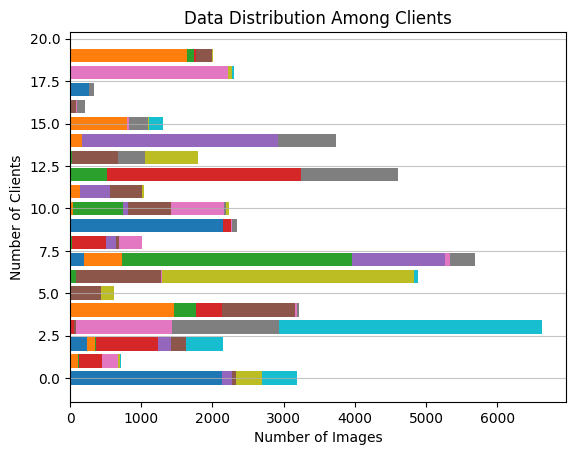

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 0.1)

In [ ]:
process(torchvision.models.vgg16(), train_loader, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:266: UserWarning: Error detected in ConvolutionBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap
    self._bootstrap_inner()
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-16-2b3149fc8712>", line 17, in train
    model_client, opt_client = local_training(model_client, opt_client, train_loader[client_idx], epochs)
  File "<ipython-input-14-8f0b330cbd23>", line 11, in local_training
    output = model_client(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return fo

### 4.4.2 VGG-16 - CIFAR-10 - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 0.5)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.3 VGG-16 - CIFAR-10 - alpha 1

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 1)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.4 VGG-16 - CIFAR-10 - IID

In [ ]:
train_loader, test_loader = iid_cifar10(num_clients, batch_size)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.5 VGG-16 - CIFAR-100 - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 0.1)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.6 VGG-16 - CIFAR-100 - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 0.5)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.7 VGG-16 - CIFAR-100 - alpha 1

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 1)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.8 VGG-16 - CIFAR-100 - IID

In [ ]:
train_loader, test_loader = iid_cifar100(num_clients, batch_size)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.9 VGG-16 - EMNIST - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 0.1)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.10 VGG-16 - EMNIST - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 0.5)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.11 VGG-16 - EMNIST - alpha 1

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 1)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.12 VGG-16 - EMNIST - IID

In [ ]:
train_loader, test_loader = iid_emnist(num_clients, batch_size)
process(torchvision.models.vgg16(), train_loader, test_loader)

### 4.4.13 ResNet-18 - CIFAR-10 - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 0.1)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.14 ResNet-18 - CIFAR-10 - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 0.5)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.15 ResNet-18 - CIFAR-10 - alpha 1

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 1)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.16 ResNet-18 - CIFAR-10 - IID

In [ ]:
train_loader, test_loader = iid_cifar10(num_clients, batch_size)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.17 ResNet-18 - CIFAR-100 - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 0.1)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.18 ResNet-18 - CIFAR-100 - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 0.5)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.19 ResNet-18 - CIFAR-100 - alpha 1

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 1)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.20 ResNet-18 - CIFAR-100 - IID

In [ ]:
train_loader, test_loader = iid_cifar100(num_clients, batch_size)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.21 ResNet-18 - EMNIST - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 0.1)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.22 ResNet-18 - EMNIST - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 0.5)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.23 ResNet-18 - EMNIST - alpha 1

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 1)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.24 ResNet-18 - EMNIST - IID

In [ ]:
train_loader, test_loader = iid_emnist(num_clients, batch_size)
process(torchvision.models.resnet18(), train_loader, test_loader)

### 4.4.25 CNN - CIFAR-10 - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 0.1)
process(CNN(), train_loader, test_loader)

### 4.4.26 CNN - CIFAR-10 - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 0.5)
process(CNN(), train_loader, test_loader)

### 4.4.27 CNN - CIFAR-10 - alpha 1

In [ ]:
train_loader, test_loader = non_iid_cifar10(num_clients, batch_size, 1)
process(CNN(), train_loader, test_loader)

### 4.4.28 CNN - CIFAR-10 - IID

In [ ]:
train_loader, test_loader = iid_cifar10(num_clients, batch_size)
process(CNN(), train_loader, test_loader)

### 4.4.29 CNN - CIFAR-100 - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 0.1)
process(CNN(), train_loader, test_loader)

### 4.4.30 CNN - CIFAR-100 - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 0.5)
process(CNN(), train_loader, test_loader)

### 4.4.31 CNN - CIFAR-100 - alpha 1

In [ ]:
train_loader, test_loader = non_iid_cifar100(num_clients, batch_size, 1)
process(CNN(), train_loader, test_loader)

### 4.4.32 CNN - CIFAR-100 - IID

In [ ]:
train_loader, test_loader = iid_cifar100(num_clients, batch_size)
process(CNN(), train_loader, test_loader)

### 4.4.33 CNN - EMNIST - alpha 0.1

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 0.1)
process(CNN(), train_loader, test_loader)

### 4.4.34 CNN - EMNIST - alpha 0.5

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 0.5)
process(CNN(), train_loader, test_loader)

### 4.4.35 CNN - EMNIST - alpha 1

In [ ]:
train_loader, test_loader = non_iid_emnist(num_clients, batch_size, 1)
process(CNN(), train_loader, test_loader)

### 4.4.36 CNN - EMNIST - IID

In [ ]:
train_loader, test_loader = iid_emnist(num_clients, batch_size)
process(CNN(), train_loader, test_loader)